# LTI

In this notebook, we use DEM to find the matrices defining an LTI system. This is the same scenario as in [1], though the experiment size is made a bit smaller (i.e. shorter in time).

In [1]:
import pickle
from pathlib import Path
from time import time
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output

import jax.numpy as jnp
import numpy as np
from dem.algo import DEMInput, DEMState, extract_dynamic
from dem.dummy import simulate_colored_lti
from jax import config
from tabulate import tabulate
from tqdm import tqdm

config.update("jax_enable_x64", True)

## Simulate the system
The system is defined by transition and output functions
$$\begin{aligned}\dot{x} &= Ax + Bv \\ y &= Cx\end{aligned}$$
where the input signal $v$ and matrix $C$ are known. The goal is to infer matrices $A$ and $B$ given observations of $y$.

We will use the same matrices $A$, $B$ and $C$ as in [1]. To make it somewhat fast for the exposition, we will make it shorter: 20 seconds instead of 32, and shift the input signal accordingly. For a more accurate reproduction of the original, see script `examples/scripts/lti.py`.

In [2]:
# lti model definition
A = np.array([[0.0484, 0.7535], [-0.7617, -0.2187]])
B = np.array([[0.3604], [0.0776]])
C = np.array(
    [[0.2265, -0.4786], [0.4066, -0.2641], [0.3871, 0.3817], [-0.1630, -0.9290]]
)
D = np.array([[0], [0], [0], [0]])

x0 = np.zeros(2)
t_max = 20 # 32 in the original
dt = 0.1
# input pulse
vs = np.exp(-0.25 * (np.arange(0, t_max, dt) - 6) ** 2).reshape((-1, 1)) # '- 6' was '- 12' in original
# noises
rng = np.random.default_rng(215)
noise_temporal_sig = 0.5
## noise precisions in the paper were exp(8)
lam_w = 8
lam_z = 8
noise_prec = np.exp(8)
noise_var = 1 / noise_prec
noise_sd = np.sqrt(noise_var)
w_sd = noise_sd
z_sd = noise_sd
# simulate
ts, xs, ys, ws, zs = simulate_colored_lti(
    A, B, C, D, x0, dt, vs, w_sd, z_sd, noise_temporal_sig, rng
)

Text(0.5, 0.98, 'True system states')

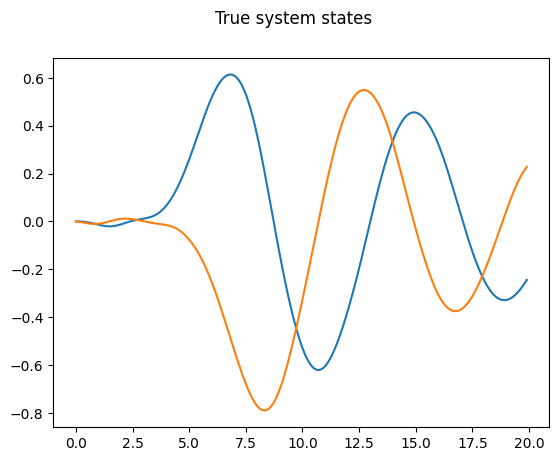

In [3]:
plt.plot(ts, xs)
plt.suptitle("True system states")

## Model definition

We define the model with the same priors as [1].

In [4]:
# embedding order (how many derivatives to track)
p = 6  # for states
d = 2  # for inputs

# how big the vectors are
m_x = 2 # for states
m_v = 1 # for inputs
m_y = 4 # for outputs

def ABC_from_params(params):
    shapes = ((m_x, m_x), (m_x, m_v), (m_y, m_x))
    cursor = 0
    matrs = []
    for rows, cols in shapes:
        size = rows * cols
        start = cursor
        end = cursor + size
        matr = params[start:end].reshape((rows, cols))
        cursor = end
        matrs.append(matr)

    A, B, C = matrs
    return A, B, C


true_params = np.concatenate([A.reshape(-1), B.reshape(-1), C.reshape(-1)])

def f_jax(x, v, params):
    A = params[0 : (m_x * m_x)].reshape((m_x, m_x))
    B = params[(m_x * m_x) : (m_x * m_x + m_x * m_v)].reshape((m_x, m_v))
    return jnp.matmul(A, x) + jnp.matmul(B, v)


def g_jax(x, v, params):
    C = params[(m_x * m_x + m_x * m_v) : (m_x * m_x + m_x * m_v + m_y * m_x)].reshape(
        (m_y, m_x)
    )
    return jnp.matmul(C, x)


## Priors
# we will assign exp(32) precision to known parameters and inputs
known_value_exp = 32
# prior on the input sequence set to the true sequence with high precision
p_v = np.exp(known_value_exp).reshape((1, 1))
eta_v = vs.copy()

# priors on parameters
# set A and B to something random, set C to the true value
eta_theta = np.concatenate([rng.uniform(-2, 2, m_x * m_x + m_x * m_v), C.reshape(-1)])
# A and B are low precision, C is high precision
p_theta_diag = np.concatenate(
    [
        np.full(m_x * m_x + m_x * m_v, np.exp(6)),
        np.full(m_y * m_x, np.exp(known_value_exp)),
    ]
)
p_theta = np.diag(p_theta_diag)

# noise hyperparameters
eta_lambda = np.zeros(2)
p_lambda = np.eye(2) * np.exp(3)

dem_input = DEMInput(
    dt=dt,
    m_x=m_x,
    m_v=m_v,
    m_y=m_y,
    p=p,
    d=d,
    ys=jnp.array(ys).astype(jnp.float64),
    eta_v=jnp.array(vs).astype(jnp.float64),
    p_v=p_v,
    eta_theta=eta_theta,
    p_theta=p_theta,
    eta_lambda=eta_lambda,
    p_lambda=p_lambda,
    f=f_jax,
    g=g_jax,
    noise_temporal_sig=noise_temporal_sig,
)

dem_state = DEMState.from_input(dem_input, x0)

We will now run the dynamic (D) step of DEM to see how the initial estimated trajectories look like. Alongside the optimization procedure, we will keep track of how long each step took.

In [5]:
lr_dynamic = 1

print("Running initial D step")
t0 = time()
dem_state.step_d(lr_dynamic)
t_dynamic_first = time() - t0

Running initial D step


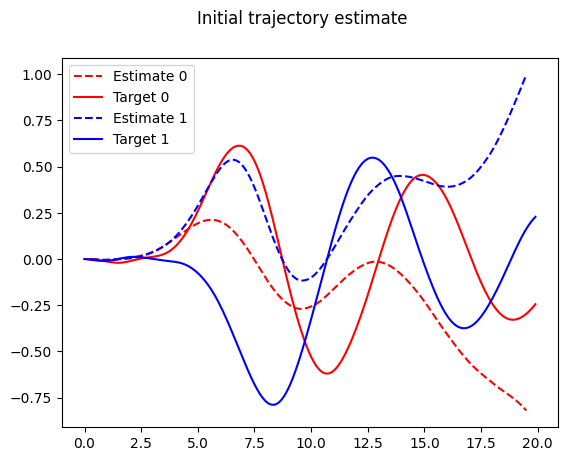

In [6]:
mu_xs, sig_xs, mu_vs, sig_vs, ts_est = extract_dynamic(dem_state)
for idx, (mu_x, x, color) in enumerate(zip(mu_xs.T, xs.T, ['red', 'blue'])):
    plt.plot(ts_est, mu_x, label=f'Estimate {idx}', linestyle='--', color=color)
    plt.plot(ts, x, label=f'Target {idx}', linestyle='-', color=color)
plt.suptitle("Initial trajectory estimate")
plt.legend()

As we can see, the initial estimates are completely wrong. This is because the parameter estimates have been initialized randomly.

Before we run the DEM procedure, we will prepare some helper functions for printing extra bits of information along the way. These will quantify how far we are from target parameters.

In [7]:
def convergence_table(A, B, C, mu_thetas, f_bars):
    f_bars = jnp.array(f_bars)
    f_bars_improv = f_bars[1:] - f_bars[:-1]
    f_bars_improv = [''] + [f'{f_bar.item():.3f}' for f_bar in f_bars_improv]
    rows = []
    with np.printoptions(precision=3, suppress=True):
        for iter, (mu_theta, f_bar) in enumerate(zip(mu_thetas, f_bars_improv)):
            A_est, B_est, C_est = ABC_from_params(mu_theta)
            A_diff = A - A_est
            B_diff = B - B_est
            C_diff = C - C_est
            row = [
                iter,
                f_bar,
                str(np.linalg.norm(A_diff)),
                str(np.linalg.norm(A_diff)/np.linalg.norm(A)),
                str(np.linalg.norm(B_diff)),
                str(np.linalg.norm(B_diff)/np.linalg.norm(B)),
                str(np.linalg.norm(C_diff)),
                str(np.linalg.norm(C_diff)/np.linalg.norm(C)),
            ]
            rows.append(row)
    return tabulate(
            rows,
            headers=(
                "Iter",
                "Free action change",
                "A err norm",
                "A err relative norm",
                "B err norm",
                "B err relative norm",
                "C err norm",
                "C err relative norm",
            ),
            tablefmt='html'
        )
    

In [8]:
trajectories = [[np.array(v) for v in extract_dynamic(dem_state)]]
param_estimates = [dem_state.mu_theta]
f_bars = []
times = {k: [] for k in ["D", "E", "M", "Precision"]}
times["D"].append(t_dynamic_first)

And now, we run the procedure itself. The whole process might around 40 minutes, but we'll have some plots along the way ✨

Note: The current implementation is somewhat _naive_, and includes computing massive Hessians directly. As such, it takes a lot of memory.

If you run out of memory, it might help to set `low_memory=True` in `dem_state.step_m(...)` or to set `low_memory=1` or `2` in `dem_state.step_e(...)`. These settings make some of the Hessian computations less vectorized and more sequential, freeing up memory but taking more time.

On the other hand, if you have plenty of memory (~20 GB), feel free to set `low_memory=False` in `dem_state.step_e(...)`. This will speed the procedure up by ~half.

Convergence information:


Iter,Free action change,A err norm,A err relative norm,B err norm,B err relative norm,C err norm,C err relative norm
0,,3.26494,2.9828,1.61137,4.37089,0,0
1,7082.398,2.35228,2.14901,1.59573,4.32846,6.70904e-11,5.14471e-11
2,2765.354,2.64247,2.41412,1.56577,4.24719,1.8624e-10,1.42815e-10
3,2155.161,2.71858,2.48366,1.43949,3.90467,5.5116e-11,4.22648e-11
4,1628.776,2.58401,2.36071,1.27217,3.45081,4.93007e-11,3.78054e-11
5,1177.328,2.35793,2.15418,1.09472,2.96946,4.19969e-11,3.22047e-11
6,800.415,2.07424,1.89499,0.960766,2.60611,3.83884e-11,2.94375e-11
7,493.076,1.77292,1.61972,0.858575,2.32891,4.48777e-11,3.44137e-11
8,312.012,1.47613,1.34857,0.762731,2.06893,5.9259e-11,4.54418e-11
9,247.992,1.19057,1.08769,0.662519,1.7971,7.37169e-11,5.65286e-11


Times in seconds:


D,E,M,Precision
7.021,69.035,24.029,3.942
0.033,50.658,4.837,0.991
0.035,51.233,6.887,1.012
0.031,50.710,7.884,1.164
0.033,48.652,7.134,1.426
0.026,50.534,7.446,1.107
0.025,53.345,6.476,0.954
0.027,48.450,6.514,1.064
0.034,49.723,6.305,1.037
0.025,53.375,6.647,0.974


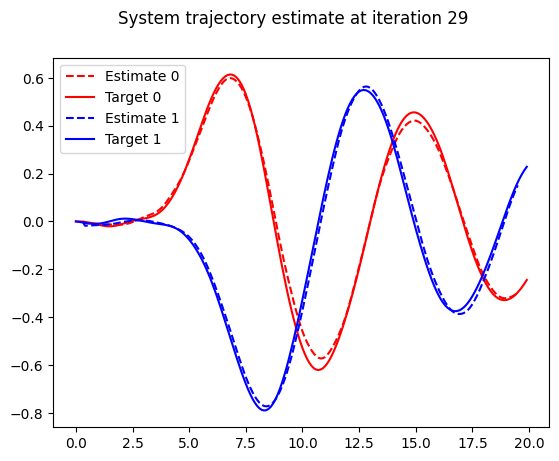

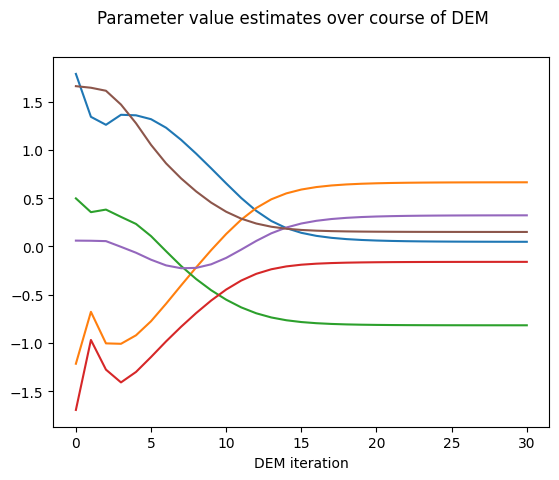

Running DEM...: 100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [31:09<00:00, 62.31s/it]


In [9]:
lr_dynamic = 1
lr_theta = 10
lr_lambda = 1
iter_lambda = 8
m_min_improv = 0.01
num_iter = 30

for i in tqdm(range(num_iter), desc="Running DEM..."):
    if i > 0:  # we already did a D step before
        print("Running D step...")
        t0 = time()
        dem_state.step_d(lr_dynamic)
        times["D"].append(time() - t0)
    
    print("Running M step...")
    t0 = time()
    dem_state.step_m(lr_lambda, iter_lambda, min_improv=m_min_improv, low_memory=False)
    times["M"].append(time() - t0)
    
    print("Running E step...")
    t0 = time()
    dem_state.step_e(lr_theta, low_memory=3)
    times["E"].append(time() - t0)
    
    print("Running precision step...")
    t0 = time()
    dem_state.step_precision()
    times["Precision"].append(time() - t0)

    param_estimates.append(dem_state.mu_theta)
    trajectories.append([np.array(v) for v in extract_dynamic(dem_state)])
    f_bar = dem_state.free_action()

    f_bars.append(f_bar)

    clear_output()
    print("Convergence information:")
    display(convergence_table(A, B, C, param_estimates, f_bars))
    print("Times in seconds:")
    display(tabulate(times, headers="keys", floatfmt=".3f", tablefmt='html'))
    mu_xs, sig_xs, mu_vs, sig_vs, ts_est = extract_dynamic(dem_state)
    for idx, (mu_x, x, color) in enumerate(zip(mu_xs.T, xs.T, ['red', 'blue'])):
        plt.plot(ts_est, mu_x, label=f'Estimate {idx}', linestyle='--', color=color)
        plt.plot(ts, x, label=f'Target {idx}', linestyle='-', color=color)
    plt.suptitle(f"System trajectory estimate at iteration {i}")
    plt.legend()
    plt.show()
    plt.plot(jnp.stack(param_estimates)[:, :(m_x * m_x + m_x * m_v)])
    plt.suptitle("Parameter value estimates over course of DEM")
    plt.xlabel("DEM iteration")
    plt.show()


As we can see it did converge ️☀️ though with somewhat of a bias (see nonzero norms of errors in $A$ and $B$ in the convergence table). This is caused by presence of noise and by the fact that DEM is a Bayesian scheme, so the final result will be biased by our choice of prior

## References

[1] A. Anil Meera and M. Wisse, “Dynamic Expectation Maximization Algorithm for
    Estimation of Linear Systems with Colored Noise,” Entropy (Basel), vol. 23,
    no. 10, p. 1306, Oct. 2021, doi: 10.3390/e23101306.